# XGBoost 분류 하이퍼파라미터 튜닝

XGBoost 라이브러리를 sklearn과의 호환을 위해 Wrappering한 클래스를 사용하면 sklearn의 GridSearchCV나 RandomizeSearchCV를 통한 하이퍼파라미터 튜닝이 가능하다.

## #01. 기본 준비

### [1] 패키지 가져오기

In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from xgboost import XGBClassifier, plot_importance, to_graphviz
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [3]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 기본 데이터 처리

In [4]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. XGBoost 학습 모델 적합

### [1] 하이퍼 파라미터 튜닝

In [5]:
%%time

estimator = XGBClassifier(
    # general params
    booster="gbtree",
    device="cpu",
    verbosity=0,
    n_jobs=get_n_jobs(),
    # train parameter
    objective="binary:logistic",
    eval_metric="error",
    early_stopping_rounds=10,
    # booster params
    random_state = get_random_state()
)

params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "gamma": [0, 1, 2, 3, 4, 5],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "reg_alpha": [1, 3, 5, 7, 9],
    "reg_lambda": [1, 3, 5, 7, 9]
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    cv=5,
    verbose=0
)

estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

### [2] RandomizedSearchCV 결과 확인

In [ ]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |         0.5 |            3 |           3 |            100 |                  1 |           4 |             0.3 |       0 |                0.9 |          0.773624 |
|  1 |           1 |            1 |           1 |            500 |                  9 |           4 |               1 |       3 |                0.9 |          0.771931 |
|  2 |           1 |            5 |           3 |            500 |                  7 |           6 |             0.7 |       5 |                

### [3] 학습 결과 확인

직접 구현한 모듈 내 기능을 사용할 수 있다.

+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.832248 |     0.824675 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.792079 |     0.717391 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.723982 |     0.702128 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |      0.10687 |     0.121495 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |      0.89313 |     0.878505 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.756501 |     0.709677 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.899969 |     0.870352 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

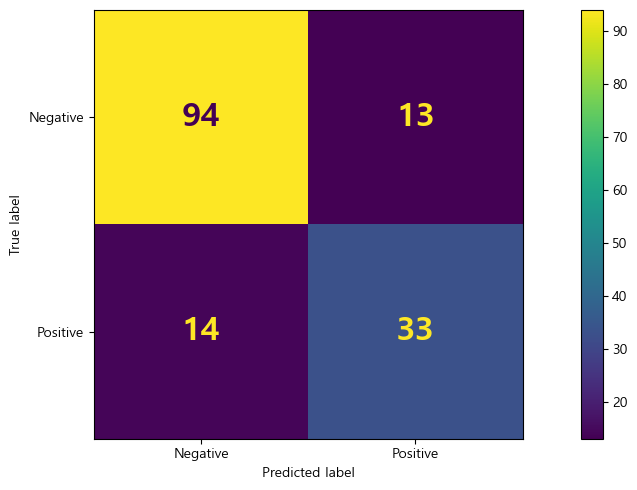

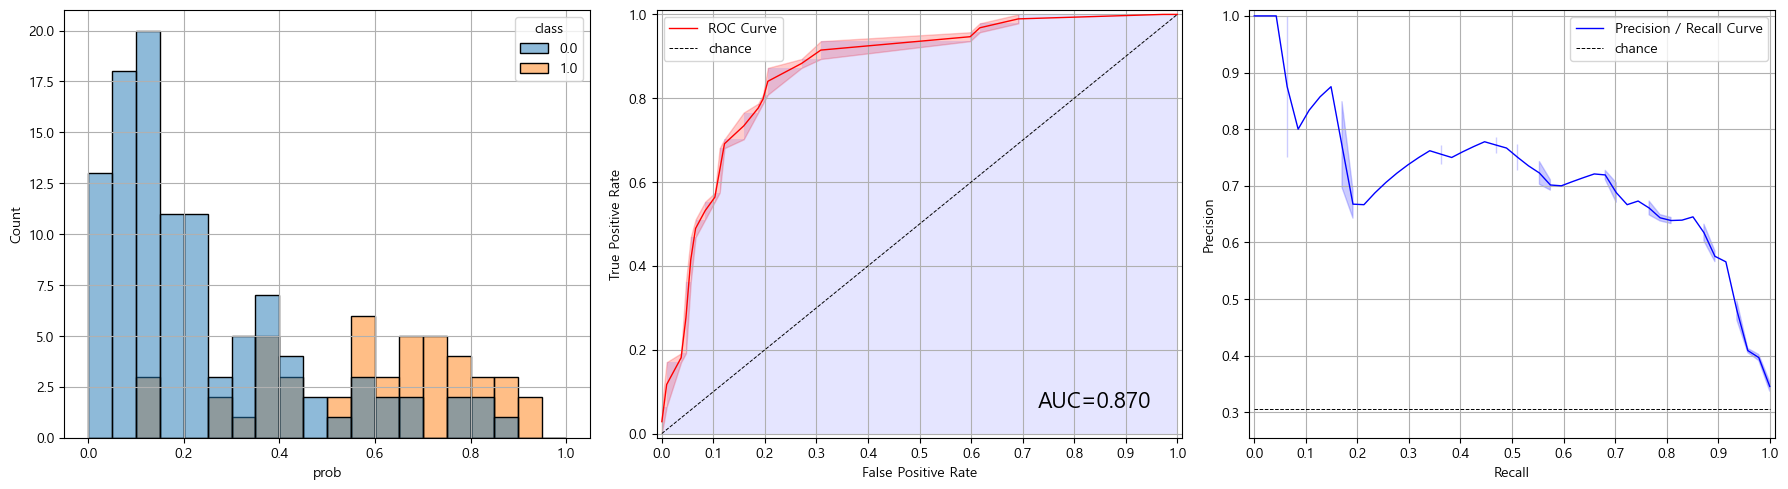


이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.

All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboo

In [ ]:
my_classification_result(
    estimator=estimator.best_estimator_, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

## #03. 모듈화 기능 확인

In [ ]:
%%time
my_xgb_classification(x_train, y_train, x_test, y_test)

NameError: name 'my_xgb_classification' is not defined